**Important announcement**

*There is an issue with the calculation of determinism in version 0.0.3 and below; update to version 0.0.4 to receive the fix (pip install --upgrade multiSyncPy). Thanks to @mrrezaie for spotting the issue. Please inform anyone you know who might be using multiSyncPy.*

**Loading packages**

First, let's import the packages we need

In [1]:
import numpy as np
import pandas as pd
from multiSyncPy import synchrony_metrics as sm
from matplotlib import pyplot as plt
import scipy.signal
import os
import scipy.stats

**Loading the data**

Now, let's load the files of the hand movement data and take a look at one in particular

In [2]:
files_folder = '/home/daniel/Downloads/envisionspeed_v2'

movement_recordings = []

for file in sorted(os.listdir(files_folder)):
    
    if '.csv' in file:
    
        movement_recordings.append(pd.read_csv(os.path.join(files_folder, file), index_col=0).iloc[1:,:])

hand_movement = movement_recordings[0]

In [3]:
hand_movement.describe()

,p1_left_hand,p1_right_hand,p1_pen,p2_left_hand,p2_right_hand,p2_pen,p3_left_hand,p3_right_hand,p3_pen,time_ms
count,57711.000000,57711.000000,57711.000000,57711.000000,57711.000000,57711.000000,57711.000000,57711.000000,57711.000000,5.771100e+04
mean,456.929709,383.336719,910.522728,741.872769,486.574781,923.003844,807.436922,307.542989,1009.149489,9.628629e+05
std,1154.931665,1043.513182,1717.132695,1534.576652,1101.658704,1433.021499,1639.103167,883.693473,1682.643756,5.558851e+05
min,-422.392154,-580.747168,-657.386494,-794.681061,-394.841074,-631.369632,-556.011812,-540.036925,-645.257999,6.700000e+01
25%,2.779663,6.207021,7.810232,6.243441,14.014322,22.679848,6.075253,15.983883,38.576181,4.814645e+05
50%,6.687220,19.887093,54.772291,23.841079,50.767108,165.193729,31.749781,44.756806,185.250428,9.628630e+05
75%,69.219043,127.743990,994.395884,608.302777,243.644386,1383.277660,628.401594,130.284519,1293.076117,1.444261e+06
max,10589.259307,11603.633993,10925.522067,12638.723955,10745.025445,11885.836702,12255.061544,11194.080643,11564.790724,1.925659e+06


In [4]:
hand_movement.head()

,p1_left_hand,p1_right_hand,p1_pen,p2_left_hand,p2_right_hand,p2_pen,p3_left_hand,p3_right_hand,p3_pen,time_ms
2,2312.567947,3612.378484,2337.838064,4271.484440,4064.872192,4134.768577,3366.912699,5427.802718,4570.341847,67.0
3,2295.581099,4134.176536,2325.284607,4246.290958,4032.403166,4163.581749,3795.698675,6149.043644,4548.626374,100.0
4,1528.920291,3652.431980,1555.969370,2842.283732,2681.183742,2822.140657,3275.594506,4926.550999,3052.460462,133.0
5,667.888871,2839.319424,688.894284,1262.734279,1165.968630,1265.421066,2491.120484,2855.550450,1364.354409,167.0
6,200.558074,2342.171066,217.899637,404.574375,348.999414,415.958726,2042.572801,1341.304866,442.943278,200.0


We can see that each individual in the team has speed measurements for their left hand and their right hand. There are also variables to track the pen of each designer, although we will leave these aside for now.  

To look at synchronisation between team members, rather than between the different hands of the same individual, we want to coalesce these variables in some way so that there is a single time series per team member. 

For the sake of this demonstration, without worrying too much about what it means, we will simply take the norm of the two variables describing each team member (maybe you can think of this as moving around a lefthand-righthand speed state space). We could have chosen any number of alternatives, like the maximum or the average between the two hands. 

Below is a function to compute the relevant norms and stack them into a numpy array in the format expected by multiSyncPy (an array of shape (number_team_members, number_time_steps)).

In [5]:
def speed_norms(data):
    
    team_members = []
    
    team_members.append(np.sqrt(np.square(data[['p1_left_hand', 'p1_right_hand']]).sum(axis=1)))
    team_members.append(np.sqrt(np.square(data[['p2_left_hand', 'p2_right_hand']]).sum(axis=1)))
    team_members.append(np.sqrt(np.square(data[['p3_left_hand', 'p3_right_hand']]).sum(axis=1)))
    
    return np.stack(team_members)

In [6]:
hand_movement_norms = speed_norms(hand_movement)

In [7]:
hand_movement_norms.shape

(3, 57711)

Now, let's inspect the first 1000 frames

In [8]:
norms_1000 = hand_movement_norms[:,:1000]

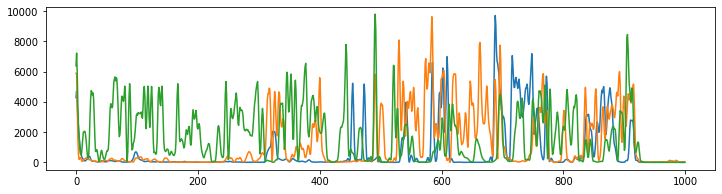

In [9]:
plt.plot(norms_1000.T)
plt.gcf().set_size_inches(12,3)

**Calculating the metrics**

With this data, we can start calculating some synchrony metrics.

Symbolic entropy is calculated quite straightforwardly:

In [10]:
sm.symbolic_entropy(norms_1000)

3.161849153264598

This gives a single overall synchrony score for the inputs. If we want, we can instead apply the function in a windowed fashion. 

Let's do that across the entire recording (not just the first 1000 time steps) and visualise the results. We will use a window size of 1000 and an increment of 500.

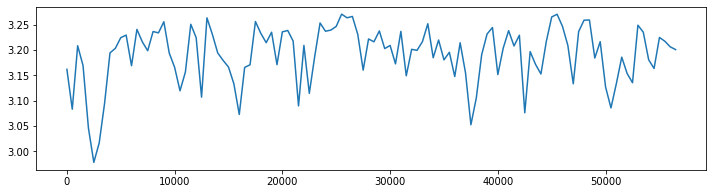

In [11]:
plt.plot(
    sm.apply_windowed(hand_movement_norms, sm.symbolic_entropy, 1000, 500)
)
plt.xticks(np.arange(0,120,step=20), np.arange(0,120,step=20)*500) ## To show the x axis in terms of video frame numbers rather than window numbers
plt.gcf().set_size_inches(12,3)

In [12]:
30*60*25

45000

Multidimensional RQA requires us to construct a recurrence matrix and pass it into the `rqa_metrics` function. Doing both things in one line:

In [13]:
sm.rqa_metrics(sm.recurrence_matrix(norms_1000, 0.5))

(0.10796796796796797, 0.8588355275356944, 3.0515475584224525, 81)

The second value above is the proportion of recurrence (multiply by 100 to get %REC). 

The additional parameter in `recurrence_matrix` is the radius. Unless there is a theoretical basis for deciding this parameter, we usually set this so that recurrence of around 1% to 5% is achieved. A smaller radius gives a lower recurrence:

In [14]:
sm.rqa_metrics(sm.recurrence_matrix(norms_1000, 0.25))

(0.04918318318318318, 0.7593926812390606, 2.4650812763395544, 80)

Calculating this in a windowed fashion is a little trickier, since we need to combine both the creation of the recurrence matrix and the calculation of RQA metrics into a single function (which we will pass into `apply_windowed`). 

Let's do that using a lambda expression and visualise the recurrence:

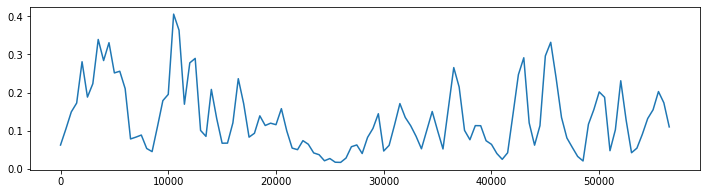

In [15]:
plt.plot(
    sm.apply_windowed(hand_movement_norms, lambda x: sm.rqa_metrics(sm.recurrence_matrix(x, 0.3)), 1000, 500)[:,0]
)
plt.xticks(np.arange(0,120,step=20), np.arange(0,120,step=20)*500) ## To show the x axis in terms of video frame numbers rather than window numbers
plt.gcf().set_size_inches(12,3)

Coherence and sum-normalized CSD are both straightforward to compute:

In [16]:
sm.coherence_team(norms_1000)

0.18393437361962076

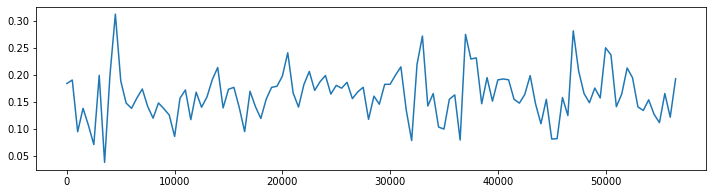

In [17]:
plt.plot(
    sm.apply_windowed(hand_movement_norms, sm.coherence_team, 1000, 500)
)
plt.xticks(np.arange(0,120,step=20), np.arange(0,120,step=20)*500) ## To show the x axis in terms of video frame numbers rather than window numbers
plt.gcf().set_size_inches(12,3)

In [18]:
sm.sum_normalized_csd(norms_1000)

0.14956055957198386

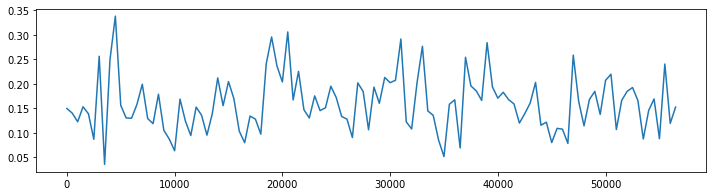

In [19]:
plt.plot(
    sm.apply_windowed(hand_movement_norms, sm.sum_normalized_csd, 1000, 500)
)
plt.xticks(np.arange(0,120,step=20), np.arange(0,120,step=20)*500) ## To show the x axis in terms of video frame numbers rather than window numbers
plt.gcf().set_size_inches(12,3)

The cluster-phase 'rho' metric requires us to do some additional preprocessing, to obtain the phase time series from the raw amplitude time series. 

There are many ways to do this, but the simplest is probably to take the Hilbert transform of the data. Below is a function to normalise the data and then extract phase using the Hilbert transform.

In [20]:
def extract_phase(data):
    
    data = (data - data.mean(axis=1).reshape(-1,1)) / data.std(axis=1).reshape(-1,1)

    return np.angle(scipy.signal.hilbert(data))

In [21]:
phases_norms_1000 = extract_phase(norms_1000)

Using the phase time series, it is possible to calculate rho. 

Note that there are two outputs, the first of which is a moment-by-moment synchrony score, and the second is an overall score across time. Below, we show just the latter.

In [22]:
sm.rho(phases_norms_1000)[1]

0.6011607884568047

Although `rho` already outputs a sequence of synchrony scores over time, if we want to, we can also look at rho over time by using the windowing function.

Note that below we use a lambda in order to take only the 'overall' rho value for each window, but apply the phase extraction outside of the lambda:

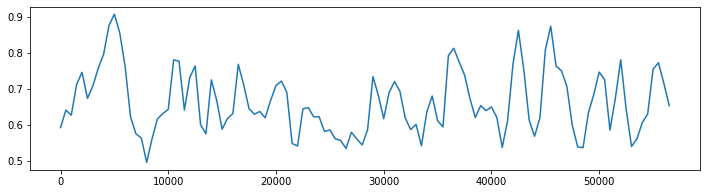

In [23]:
plt.plot(
    sm.apply_windowed(extract_phase(hand_movement_norms), lambda x: sm.rho(x)[1], 1000, 500)
)
plt.xticks(np.arange(0,120,step=20), np.arange(0,120,step=20)*500) ## To show the x axis in terms of video frame numbers rather than window numbers
plt.gcf().set_size_inches(12,3)

In case you were interested, let's plot the different metrics together over time (after normalising them):

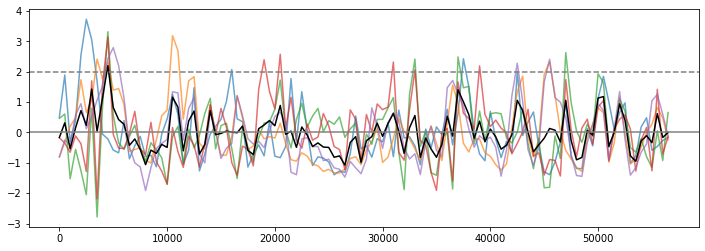

In [24]:
def normalise(data):
    
    return (data - data.mean()) / data.std()

metrics_over_time = np.stack([
    normalise(-1 * sm.apply_windowed(hand_movement_norms, sm.symbolic_entropy, 1000, 500)),
    normalise(sm.apply_windowed(hand_movement_norms, lambda x: sm.rqa_metrics(sm.recurrence_matrix(x, 0.3)), 1000, 500)[:,0]),
    normalise(sm.apply_windowed(hand_movement_norms, sm.coherence_team, 1000, 500)),
    normalise(sm.apply_windowed(hand_movement_norms, sm.sum_normalized_csd, 1000, 500)),
    normalise(sm.apply_windowed(extract_phase(hand_movement_norms), lambda x: sm.rho(x)[1], 1000, 500))
])

plt.plot(
     metrics_over_time.T, alpha = 2/3
)
plt.plot(
     metrics_over_time.mean(axis=0).T, color='black'
)
plt.axhline(0, color='grey')
plt.axhline(2, color='grey', linestyle='dashed')
plt.xticks(np.arange(0,120,step=20), np.arange(0,120,step=20)*500) ## To show the x axis in terms of video frame numbers rather than window numbers
plt.gcf().set_size_inches(12,4)

The last synchrony calculation is the test on the Kuramoto order parameter. This operates on a collection of recordings and examines whether the observed average phases differ from the expectation from a null hypothesis. 

We will apply this to the entire collection of recordings, after converting them to phase time series. 

In [25]:
phase_time_series = []

for recording in movement_recordings:
    
    norms = speed_norms(recording)
    
    phases = extract_phase(norms)
    
    phase_time_series.append(phases)

When performing the test, the first numer is the p-value, the second is the t-statistic and the third is the degrees of freedom. 

In [26]:
sm.kuramoto_weak_null(phase_time_series)

(3.2857616769036294e-11, 19.14860732086465, 13)

**Exercise:** 

For the first 1000 time steps of the second recording, compute the:
 * symbolic entropy
 * recurrence (using a radius of 0.25)
 * coherence
 * sum-normalised CSD
 * overall 'rho'

Your results should be:
 * 3.113
 * 0.121
 * 0.187
 * 0.192
 * 0.630

In [27]:
hand_movement_2 = movement_recordings[1]

## Code to go here

**Assumption of the test on the Kuramoto paramter, and, Surrogate data**

You may remember that one of the key assumptions of the Kuramoto test is that there is a relatively uniform distribution of phase values. Applying the Hilbert transform to movement data may however lead to distributions that are skewed by long sequences of inactivity. 

To check the distribution visually, we can plot a histogram:

(array([328126., 292985., 169265., 110438., 121190., 136778., 136967.,
        121350., 110840., 169822., 292935., 327815.]),
 array([-3.14159110e+00, -2.61799256e+00, -2.09439403e+00, -1.57079549e+00,
        -1.04719696e+00, -5.23598421e-01,  1.14305109e-07,  5.23598650e-01,
         1.04719719e+00,  1.57079572e+00,  2.09439426e+00,  2.61799279e+00,
         3.14159133e+00]),
 <BarContainer object of 12 artists>)

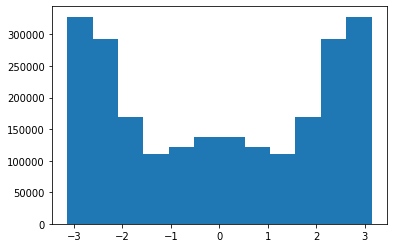

In [28]:
plt.hist(np.concatenate([x.flatten() for x in phase_time_series]), bins=12)

The histogram suggests that values around +/-pi are about three times as likely as values around zero. This does not conform with the assumption of uniformity, and means that the results of the Kuramoto test may be misleading. 

Is there another way to tell if there is above chance-level synchrony in the recordings? Yes, we can create surrogate data to act as a baseline against which to compare our observed values. 

multiSyncPy provides two simple ways to create surrogate data: (1) to take time windows and rearrange them separately for each variable, and (2) to rearrange the variables across time series (so participants end up in different groups). We will demonstrate the latter approach here. Note that this approach requires time series to be the same length, so we will take the first 50000 time steps of each recording. 

In [29]:
all_norms = [speed_norms(x) for x in movement_recordings]

all_norms_shortened = np.stack([x[:,:50000] for x in all_norms])

all_norms_shortened_surrogate = sm.shuffle_recordings(all_norms_shortened)

Now we can compare results obtained from the real data to results from the surrogate data. For example, let's use the coherence to do that. 

In [30]:
coherences = [sm.coherence_team(x) for x in all_norms_shortened]

coherences_surrogate = [sm.coherence_team(x) for x in all_norms_shortened_surrogate]

scipy.stats.ttest_ind(coherences, coherences_surrogate, equal_var=False)

Ttest_indResult(statistic=2.879530809789159, pvalue=0.010221184204766146)

<ErrorbarContainer object of 3 artists>

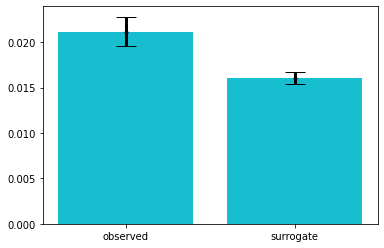

In [31]:
plt.bar(['observed','surrogate'], 
        [np.mean(coherences), np.mean(coherences_surrogate)], color='tab:cyan')
plt.errorbar(['observed','surrogate'], 
             [np.mean(coherences), np.mean(coherences_surrogate)], 
             yerr=[np.std(coherences, ddof=1)/np.sqrt(len(coherences)), np.std(coherences_surrogate, ddof=1)/np.sqrt(len(coherences_surrogate))],
             fmt=".", capsize=10, linewidth=3, color='black')

Although the sample size is small, the t-test also suggests that the observed synchronisation is greater than the surrogate baseline. 